# Model Result Analysis

## Import Packages

In [225]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.neighbors import KernelDensity

## Import Data

In [190]:
sub = pd.read_csv('submission.csv')
test = pd.read_csv('./dataset/test_weather_FE.csv')
test_EDA = pd.read_csv('./dataset/test_EDA.csv')

## Recommendation

Based on the probability of having West Nile Virus (WNV) provided by the model, we can prioritise the number of traps to be sprayed. Generally mosquito's lifecycle is roughly 21 days, therefore, the spraying will be performed every 3 weekly. As having false negative has much adverse effect to the economy and human welfare, we will skew the threshold of considering a trap to have a WNV from the usual 0.5 to 0.395 (based on our analysis in previous chapter). Having lower threshold means that traps with 50-50% chance of having and not having WNV will also be sprayed (more conservative). Even those with 40-60% chance of having and not having WNV will also be sprayed as 40% is still bigger than 39.5%. 

In [226]:
final = pd.concat([sub, test, test_EDA[['Trap']]], axis=1)
final.drop(columns=['Id'], inplace=True)
final['Date'] = pd.to_datetime(final['Date'])
final.set_index('Date', inplace=True)
final['year'] = final.index.year
final.head(2)

,WnvPresent,Latitude,Longitude,week_of_year,dist_to_stat_1,dist_to_stat_2,infection_rate,"('high_rate',)","('north_high',)","('north_low',)",...,Cool,Depart,DarkHours,Tavg_Rol7,DewPoint_Rol7,WetBulb_Rol7,RelHumidity_Rol7,AvgSpeed_Rol7,Trap,year
Date,,,,,,,,,,,,,,,,,,,,,
2008-06-11,0.035189,41.95469,-87.800991,24,0.138026,0.17566,0.0,0.0,0.0,1.0,...,10.0,7,8.833333,74.071429,60.285714,65.642857,0.678617,10.771429,T002,2008
2008-06-11,0.035189,41.95469,-87.800991,24,0.138026,0.17566,0.0,0.0,0.0,1.0,...,10.0,7,8.833333,74.071429,60.285714,65.642857,0.678617,10.771429,T002,2008


In [227]:
summary = final.groupby(['year', 'Trap', 'week_of_year'])[['WnvPresent']].max()
summary['to_spray'] = (summary['WnvPresent'] > 0.395).astype(int)
summary.head()

WnvPresent  to_spray
year Trap week_of_year                      
2008 T001 24              0.034161         0
          25              0.025874         0
          26              0.084594         0
          27              0.022425         0
          28              0.056566         0

In [228]:
def spray_decision(year, trap, ax):
    x = summary[np.in1d(summary.index.get_level_values(0), [year]) & 
                         np.in1d(summary.index.get_level_values(1), [trap])]
    ax.plot(x.index.get_level_values(2), x['WnvPresent'], label='Probability of Having WNV')
    ax.hlines(y=0.395, xmin=24, xmax=40, colors='red', label='threshold')
    ax.plot(x.index.get_level_values(2), x['to_spray'], label='To Spray?')
    ax.set_title('Decision to Spray on Trap {} in {}'.format(trap, year))
    ax.legend()

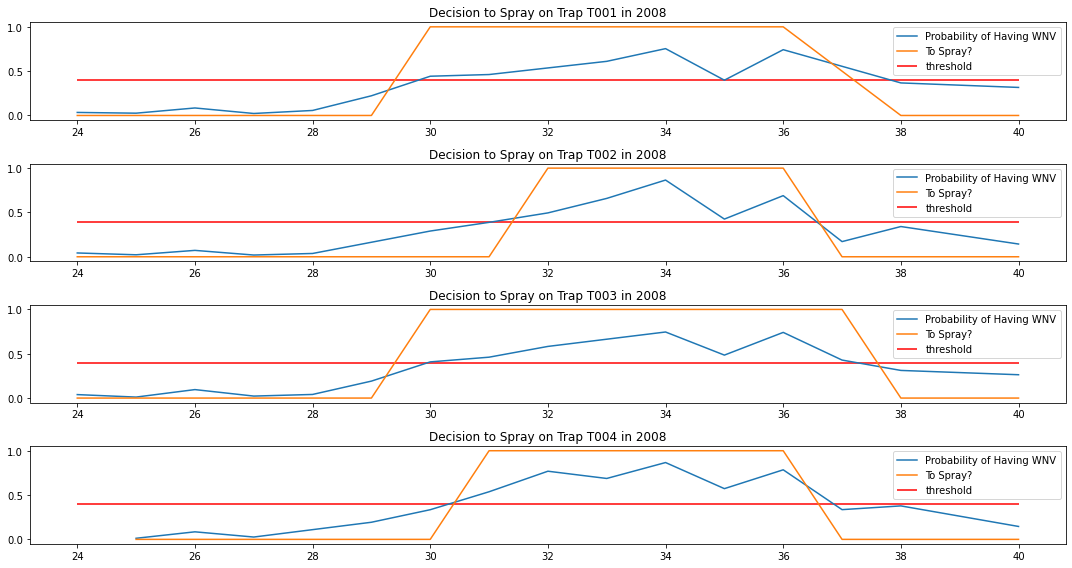

In [229]:
fig, ax = plt.subplots(nrows=4, figsize=(15, 8))
ax = ax.ravel()
spray_decision(2008, 'T001', ax[0])
spray_decision(2008, 'T002', ax[1])
spray_decision(2008, 'T003', ax[2])
spray_decision(2008, 'T004', ax[3])
plt.tight_layout()

**Observations:**
- As we can see, the probability of having WNV increases as early as week 29 and ends latest on week 38. This way, we can perform selective spraying during WNV high season to avoid spraying whole season round to save valueable resources.

In [230]:
# If we spray everywhere
no_of_week = final.groupby('year')['week_of_year'].nunique()
no_of_trap = final.groupby('year')['Trap'].nunique()
total_spray = no_of_week*no_of_trap

spray_count = summary.groupby(['year', 'Trap'])[['to_spray']].sum()
spray_count['count'] = spray_count.apply(lambda x: math.ceil(x['to_spray']/3), axis=1)
model_spray = spray_count.groupby(['year'])['count'].sum()

for no, year in enumerate(final['year'].unique()):
    print("In {}".format(year))
    print("Baseline case : {} times spraying".format(math.ceil(total_spray[year]/3)))
    print("Based on model : {} times spraying".format(model_spray[year]))
    print()


In 2008
Baseline case : 806 times spraying
Based on model : 351 times spraying

In 2010
Baseline case : 856 times spraying
Based on model : 368 times spraying

In 2012
Baseline case : 755 times spraying
Based on model : 281 times spraying

In 2014
Baseline case : 906 times spraying
Based on model : 258 times spraying



**Observations:**
- As we can see here, the model helps us to reduce the budget significantly by up to 75%! This is with the model being more on the safe side as we shifted the threshold to <0.5. If we have extra budget on hand, we can even spray to more places. However, if our budget is on the more limited side, we also still can prioritise which trap to spray and when by reducing the threshold slightly closer to 0.5 **but not less than 0.5**. This is because the earlier premise we set up that **False Negative** is going to cost us more than **False Positive**.

## Recommendation

Earlier we see that our trap grouping features were significant in our chosen model. We expect that our next model will include a study of demographic and geographical features around each trap to attempt to glean patterns which would assist us in broadly grouping our Traps to make more effective predictive features. These demographic and geographical features can range from housing prices nearby (signifying the wealth distribution of people living in the area) to nearby landmarks such as ponds or parks. 

We will also attempt to include weather data from months before May as conditions in Winter and Spring may inform us more about the mosquito population to expect in the summer for a given year.

## Conclusion

In this project, we first determined that our data was seasonal in nature which allowed us to create appropriate features to predict the prescence of WNV in mosquito pools in weeks in a year. Our best model was chosen by looking at:
1. The highest Sensitivity (minimum/0 False Negatives)
2. With as high as possible Precision (minimum False Positives)

This was determined through evaluation through a Sensitivity-Precision curve after fitting.

Our model allows us to save on pesticide spraying costs, both financial and side effects, while helping us safely identify all areas suspected to be infected mosquito hot spots.